In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

/tmp/ipykernel_65227/2301828658.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
df = pd.read_csv('ice_cream.csv')
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [5]:
df.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)
df.head()

,date,production
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [6]:
df['date'] = pd.to_datetime(df.date)
df.head()

,date,production
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [7]:
df.set_index('date', inplace=True)
df.head()

,production
date,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [8]:
start_date = pd.to_datetime('2010-01-01')
df = df[start_date:]
df.head()

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


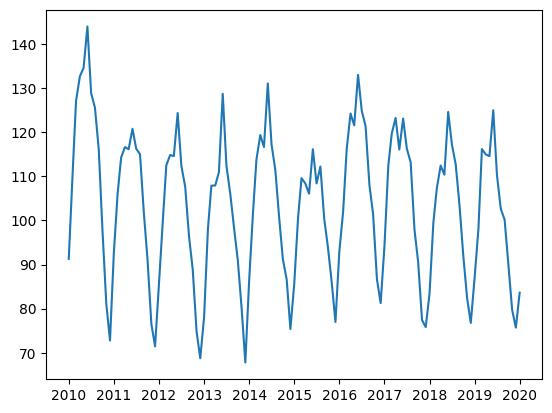

In [9]:
plt.plot(df.production)
plt.show()

# ACF

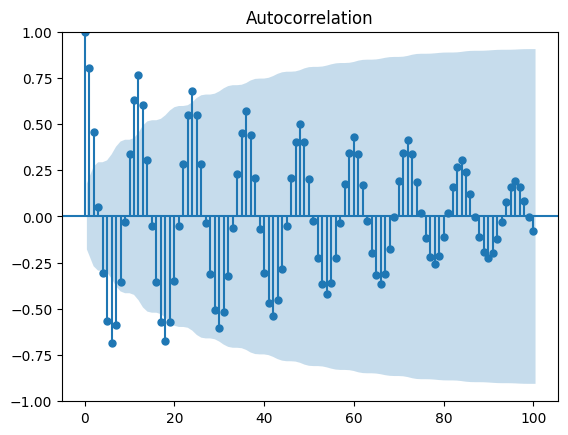

In [10]:
acf_plot = plot_acf(df.production, lags=100)

#### Based on decaying PCF we are likely dealing with Auto Regressive model

# PACF

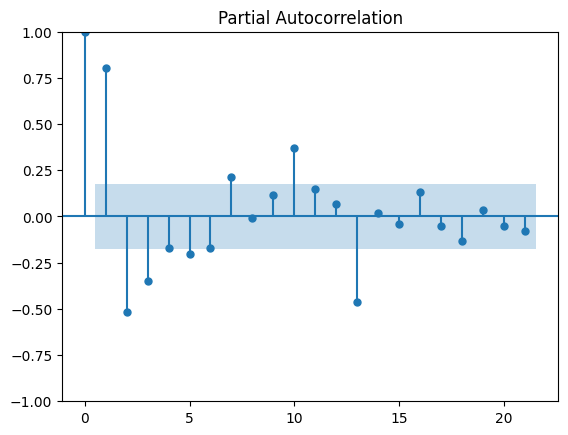

In [11]:
pacf_plot = plot_pacf(df.production)

#### Based on PACF, we can start an auto-regressive model based on 1,2,3,10 and 13

# Stock Data

In [12]:
# Getting stocks data
import yfinance as yf
tickerSymbol = 'SPY'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d', start='2015-1-1', end='2020-1-1')
tickerDf = tickerDf[['Close']]
tickerDf.head()

/media/crsdvaibhav/New Volume/notes/finance/time-series/env/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,Close
Date,
2015-01-02 00:00:00-05:00,174.806732
2015-01-05 00:00:00-05:00,171.649811
2015-01-06 00:00:00-05:00,170.033112
2015-01-07 00:00:00-05:00,172.151871
2015-01-08 00:00:00-05:00,175.206757


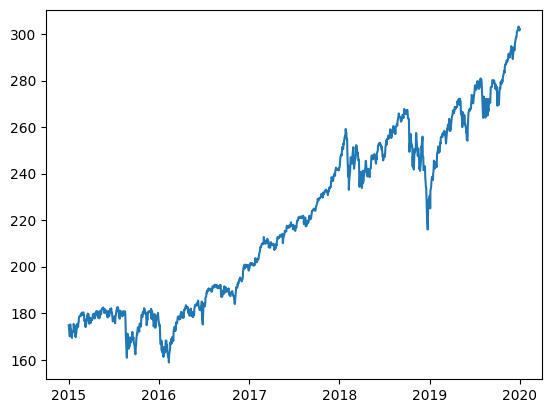

In [13]:
plt.plot(tickerDf.Close)
plt.show()

#### This is not stationary and is increasing, so we can plot first difference of this series, which is the price on this day minus the stock price on the previous day

In [14]:
first_diffs = tickerDf.Close.values[1:] - tickerDf.Close.values[:-1]
first_diffs = np.concatenate([first_diffs, [0]])
tickerDf['FirstDifference'] = first_diffs
tickerDf.head()

,Close,FirstDifference
Date,,
2015-01-02 00:00:00-05:00,174.806732,-3.156921
2015-01-05 00:00:00-05:00,171.649811,-1.616699
2015-01-06 00:00:00-05:00,170.033112,2.118759
2015-01-07 00:00:00-05:00,172.151871,3.054886
2015-01-08 00:00:00-05:00,175.206757,-1.404068


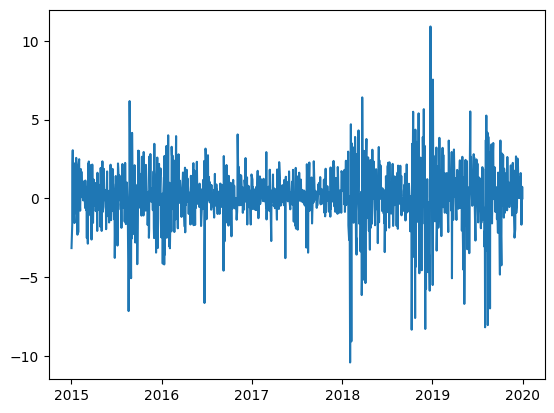

In [15]:
plt.plot(tickerDf.FirstDifference)
plt.show()

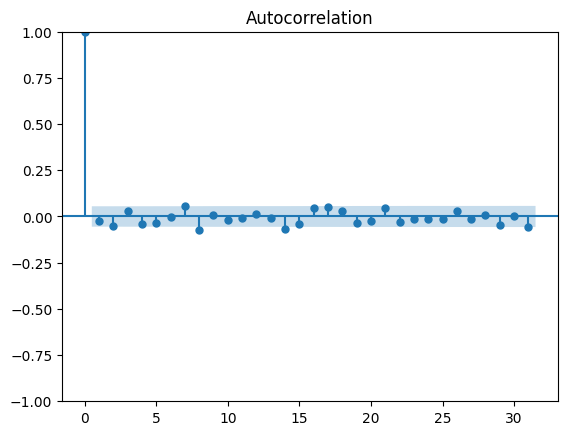

In [16]:
acf_plot = plot_acf(tickerDf.FirstDifference)

#### ACF is not helpful

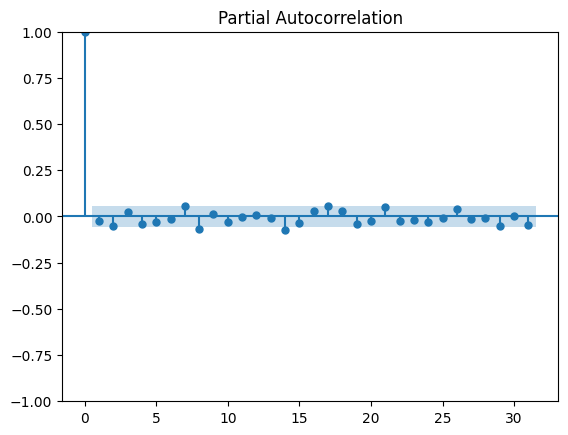

In [17]:
pacf_plot = plot_pacf(tickerDf.FirstDifference)

#### This is also not that much helpful, which tells that stock price prediction is not an easy process

# Augmented Dickey Fuller Test

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
def generate_ar_process(lags, coefs, length):
    
    #cast coefs to np array
    coefs = np.array(coefs)
    
    #initial values
    series = [np.random.normal() for _ in range(lags)]
    
    for _ in range(length):
        #get previous values of the series, reversed
        prev_vals = series[-lags:][::-1]
        
        #get new value of time series
        new_val = np.sum(np.array(prev_vals) * coefs) + np.random.normal()
        
        series.append(new_val)
        
    return np.array(series)

In [20]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF statistic : %f' % result[0])
    print('p-value : %f' % result[1])

# AR(1) Process

#### Stationary

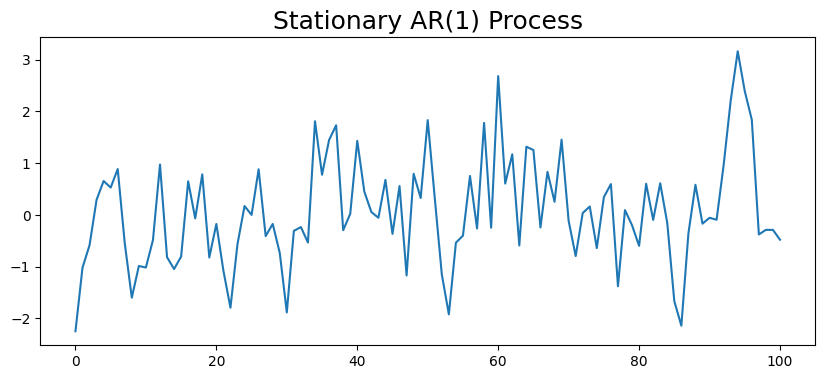

In [21]:
ar_1_process = generate_ar_process(1, [.5], 100)
plt.figure(figsize=(10,4))
plt.plot(ar_1_process)
plt.title('Stationary AR(1) Process', fontsize=18)
plt.show()

In [22]:
perform_adf_test(ar_1_process)

ADF statistic : -5.238029
p-value : 0.000007


#### Non-stationary

Text(0.5, 1.0, 'Non-Stationary AR(1) Process')

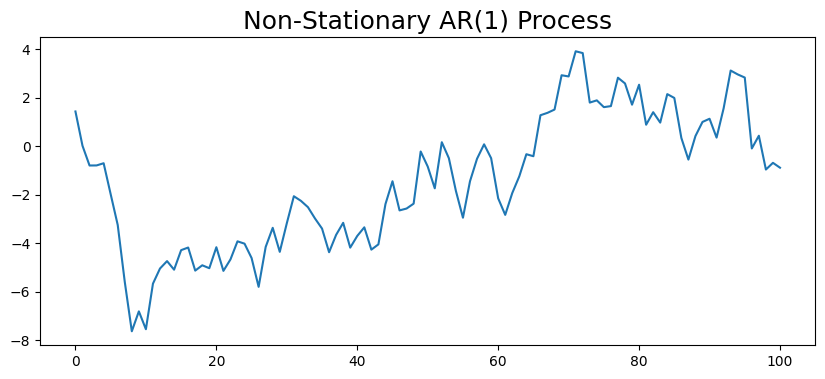

In [23]:
ar_1_process_unit_root = generate_ar_process(1, [1], 100)
plt.figure(figsize=(10,4))
plt.plot(ar_1_process_unit_root)
plt.title('Non-Stationary AR(1) Process', fontsize=18)

In [24]:
perform_adf_test(ar_1_process_unit_root)

ADF statistic : -1.981963
p-value : 0.294537


# AR(2) Process

#### Stationary

Text(0.5, 1.0, 'Stationary AR(2) Process')

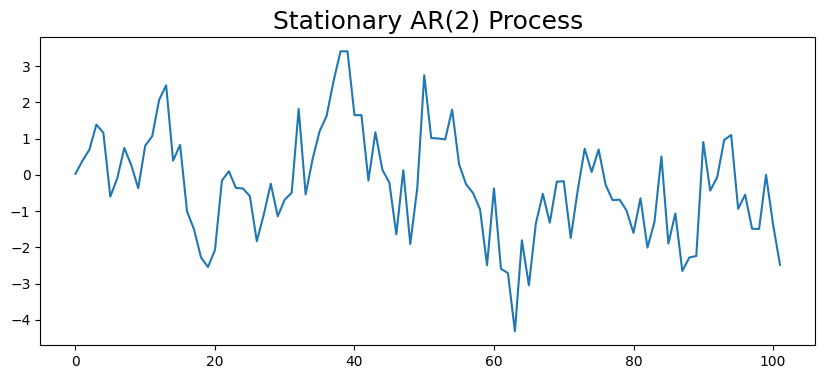

In [25]:
ar_2_process = generate_ar_process(2, [.5, .3], 100)
plt.figure(figsize=(10,4))
plt.plot(ar_2_process)
plt.title('Stationary AR(2) Process', fontsize=18)

In [26]:
perform_adf_test(ar_2_process)

ADF statistic : -3.245983
p-value : 0.017473


#### Non-stationary

Text(0.5, 1.0, 'Non-Stationary AR(2) Process')

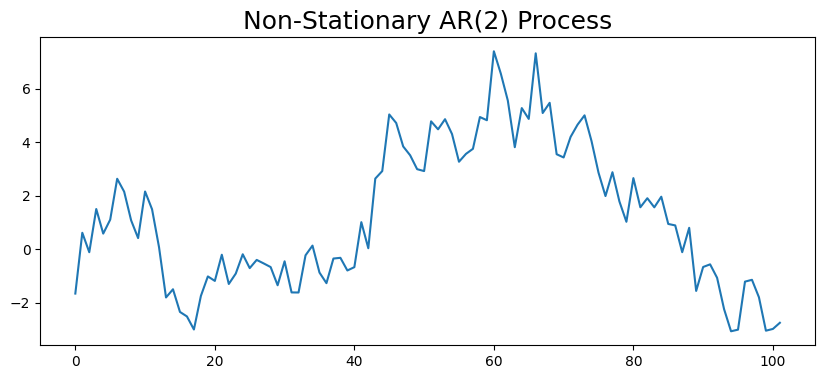

In [27]:
ar_2_process_unit_root = generate_ar_process(2, [.7, .3], 100)
plt.figure(figsize=(10,4))
plt.plot(ar_2_process_unit_root)
plt.title('Non-Stationary AR(2) Process', fontsize=18)

In [28]:
perform_adf_test(ar_2_process_unit_root)

ADF statistic : -0.918530
p-value : 0.781809


# AR Model

In [29]:
from statsmodels.tsa.arima.model import ARIMA
from time import time
from datetime import datetime
from datetime import timedelta

In [30]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [31]:
production_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], index_col=0, date_parser=parser)
production_ice_cream.squeeze('columns')

/tmp/ipykernel_65227/2938833982.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  production_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], index_col=0, date_parser=parser)


DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: IPN31152N, Length: 577, dtype: float64

In [32]:
production_ice_cream.rename(columns = {'IPN31152N':'production'}, inplace=True)
production_ice_cream.head()

,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [33]:
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [34]:
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

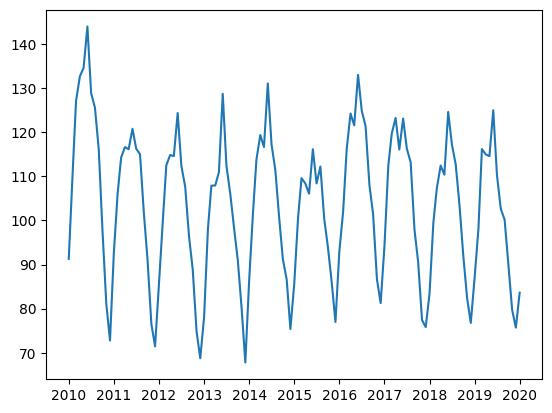

In [35]:
plt.plot(production_ice_cream)
plt.show()

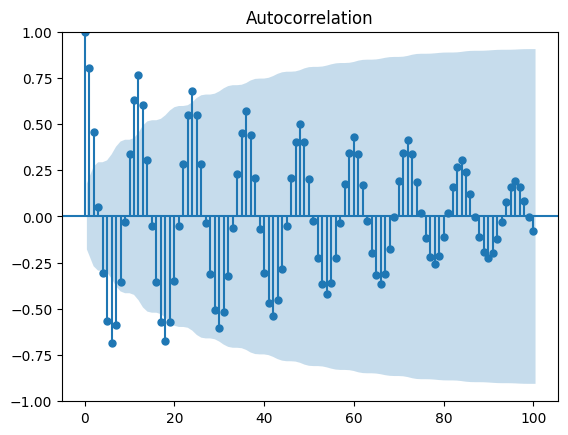

In [36]:
acf_plot = plot_acf(production_ice_cream, lags=100)

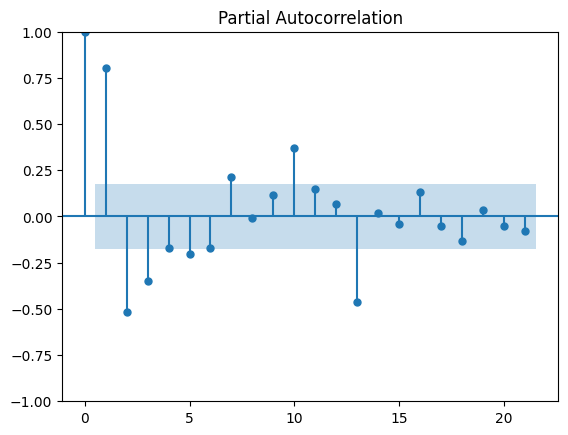

In [37]:
pacf_plot = plot_pacf(production_ice_cream)

#### We start with AR(3), with lags 1,2,3

In [38]:
# Training and test sets

train_end = datetime(2018,12,1)
test_end = datetime(2019,12,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

In [39]:
# Fit the AR model

model = ARIMA(train_data, order=(13,0,0))
start = time()
model_fit = model.fit()
end = time()
print("Model fitting time: ", end-start)

Model fitting time:  1.0686650276184082


/media/crsdvaibhav/New Volume/notes/finance/time-series/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                ARIMA(13, 0, 0)   Log Likelihood                -309.151
Date:                Tue, 13 Feb 2024   AIC                            648.303
Time:                        20:47:59   BIC                            688.535
Sample:                    01-01-2010   HQIC                           664.615
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.9878      1.634     63.658      0.000     100.786     107.189
ar.L1          0.8838      0.080     11.048      0.000       0.727       1.041
ar.L2          0.0283      0.115      0.245      0.8

#### The P>|Z| tells the P Values and those above 0.5 can be neglected 

In [41]:
# predictions

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data.production - predictions


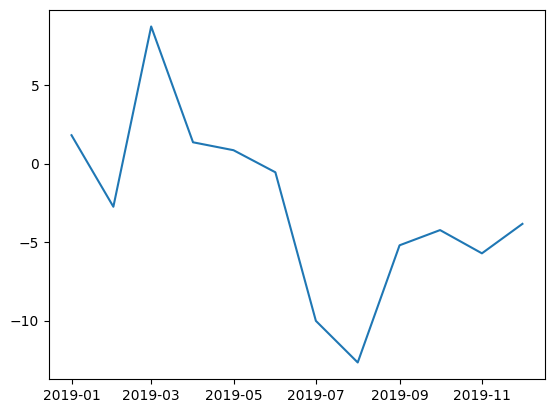

In [42]:
plt.plot(residuals)
plt.show()

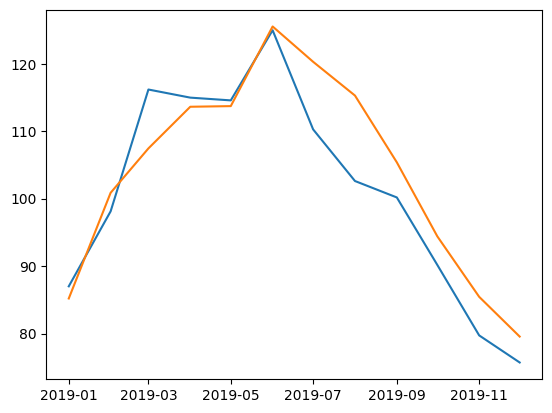

In [43]:
plt.plot(test_data.production)
plt.plot(predictions)
plt.show()

In [44]:
print('Mean Absolute Percent Error: ', round(np.mean(abs(residuals/test_data.production)),4))

Mean Absolute Percent Error:  0.0486


In [45]:
print('Root Mean Squared Error: ', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error:  6.0776407695816355


#### Evaluating a time series:
Generally in time series models, the predictions for a long time ahead are not good as the predictions turn to the global mean. So we do what is called a rolling forecast origin. Lets say we have to predict data for two months ahead, then I can train the model for k-2 months and test on 2 months, then for the next month incorporate the k-1th data and re train the model to predict for k+1th month, and so on.

- Train on 1,2....k-3 -> predict k-2
- Train on 1,2....k-2 -> predict k-1
- Train on 1,2....k-1 -> predict k

and so on, and then average all predictions

In [47]:
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1) : test_end]

In [48]:
predictions_rolling = pd.Series()
for end_date in test_data.index:
    train_data = production_ice_cream[:end_date-timedelta(days=1)]
    model = ARIMA(train_data, order=(3,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]

In [51]:
residuals_rolling = test_data.production - predictions_rolling

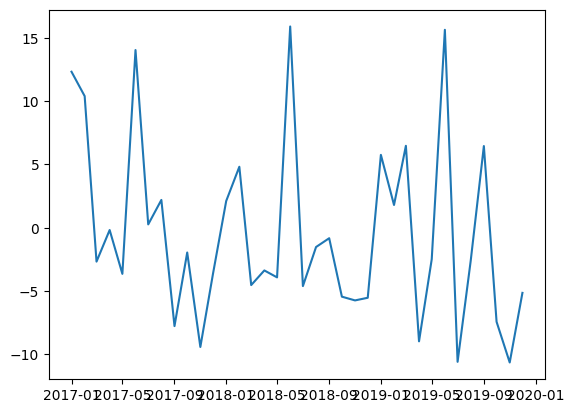

In [52]:
plt.plot(residuals_rolling)
plt.show()

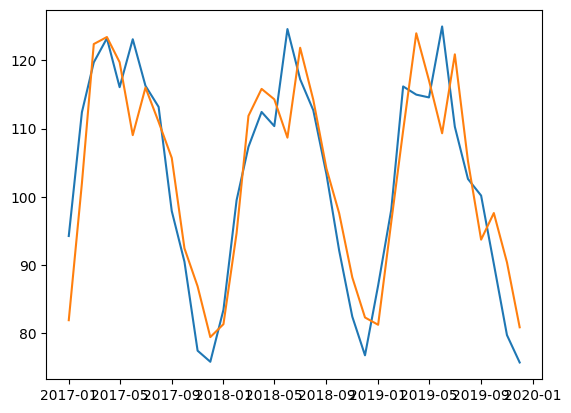

In [54]:
plt.plot(test_data.production)
plt.plot(predictions_rolling)
plt.show()

#### Hence here you can see a much better fit